In [6]:
from symtable import Class

import torch
import torch.nn as nn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
from instances.wrappers import get_dataset
from instances.models import Classifier

/home/felipe/Projects/heuristics-fsmp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [60]:
datasets = [
    "letter_recognition",
    # "beans",
    # "brain_tumor",
    # "cifar",
    # "cats_and_dogs",
]

backbones = [
    "resnet18"
]

In [63]:
class Tracker:
    def __init__(self, backbone, dataset):
        self.backbone = backbone
        self.dataset = dataset
        
        self.step = []
        self.epoch = []
        self.loss = []
        self.acc = []
    
    def __call__(self, step, epoch, loss, acc=None):
        self.step.append(step)
        self.epoch.append(epoch)
        self.loss.append(loss)
        if acc is not None:
            self.acc.append(acc)
        
    def plot_loss(self, ax, *args, **kwargs):
        ax.plot(self.step, self.loss, label=f"{self.backbone}_{self.dataset}", *args, **kwargs)
        ax.redraw_in_frame()
    
    def plot_acc(self, ax, *args, **kwargs):
        ax.plot(self.step, self.acc, label=f"{self.backbone}_{self.dataset}", *args, **kwargs)
        ax.redraw_in_frame()
        

In [67]:
def accuracy(logits, labels):
    preds = torch.softmax(logits, dim=1).argmax(dim=1)
    return (preds == labels).float().mean()

In [68]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [76]:
batch_size = 128
n_epochs = 16
epochs_before_unfreeze = int(n_epochs - 2)
lr = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_fn = nn.functional.cross_entropy

loss_tracker = {
    "train": {f"{backbone}_{dataset}": Tracker(backbone, dataset) for backbone in backbones for dataset in datasets},
    "validation": {f"{backbone}_{dataset}": Tracker(backbone, dataset) for backbone in backbones for dataset in datasets}
}


for dataset in datasets:
    for backbone in backbones:
        name = f"{backbone}_{dataset}" 
        print(f"training {name}...")
        train, validation, test, n_classes= get_dataset(dataset, batch_size=batch_size)
        model = Classifier(backbone, n_classes, n_hidden=128).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler_decay = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
        scheduler_backbone = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[epochs_before_unfreeze], gamma=0.1)
        
        step_train = 0
        step_validation = 0
        
        # freeze backbone
        for param in model.model[:2].parameters():
            param.requires_grad = False

        for n in tqdm(range(epochs_before_unfreeze), desc="head"):
            model.train()
            for i, batch in enumerate(train):
                x, y = batch["image"], batch["label"]
                x = x.to(device)
                y = y.to(device)
                optimizer.zero_grad()
                
                logits = model(x)
                loss = loss_fn(logits, y)
                loss.backward()
                
                optimizer.step()
                scheduler_decay.step()
                scheduler_backbone.step()
                
                loss_tracker["train"][name](step_train, n, loss.item(), accuracy(logits, y))
                step_train += 1
                
            model.eval()
            for i, batch in enumerate(validation):
                x, y = batch["image"], batch["label"]
                x = x.to(device)
                y = y.to(device)
                with torch.no_grad():
                    logits = model(x)
                    loss = loss_fn(logits, y)
                
                loss_tracker["validation"][name](step_validation, n, loss.item(), accuracy(logits, y))
                step_validation += 1
                
                                   
        # unfreeze backbone
        for param in model.model[:2].parameters():
            param.requires_grad = True
                
        for n in tqdm(range(int(n_epochs - epochs_before_unfreeze)), desc="head + backbone"):
            model.train()
            for i, batch in enumerate(train):
                x, y = batch["image"], batch["label"]
                x = x.to(device)
                y = y.to(device)
                optimizer.zero_grad()
                
                logits = model(x)
                loss = loss_fn(logits, y)
                loss.backward()
                
                optimizer.step()
                scheduler_decay.step()
                scheduler_backbone.step()
                
                loss_tracker["train"][name](step_train, n, loss.item(), accuracy(logits, y))
                step_train += 1
                
            model.eval()
            for i, batch in enumerate(validation):
                x, y = batch["image"], batch["label"]
                x = x.to(device)
                y = y.to(device)
                with torch.no_grad():
                    logits = model(x)
                    loss = loss_fn(logits, y)

                loss_tracker["validation"][name](step_validation, n, loss.item(), accuracy(logits, y))
                step_validation += 1

training resnet18_letter_recognition...


head + backbone: 100%|██████████| 2/2 [04:02<00:00, 121.18s/it]


Text(0.5, 1.0, 'loss')

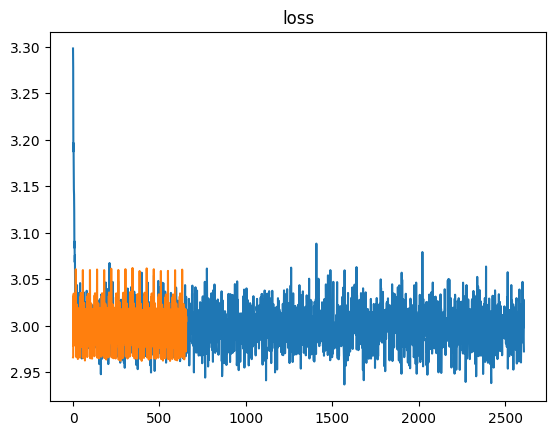

In [77]:
plt.figure()
ax = plt.gca()
loss_tracker["train"]["resnet18_letter_recognition"].plot_loss(
    ax, c="tab:blue"
)
loss_tracker["validation"]["resnet18_letter_recognition"].plot_loss(
    ax, c="tab:orange"
)
plt.title("loss")

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

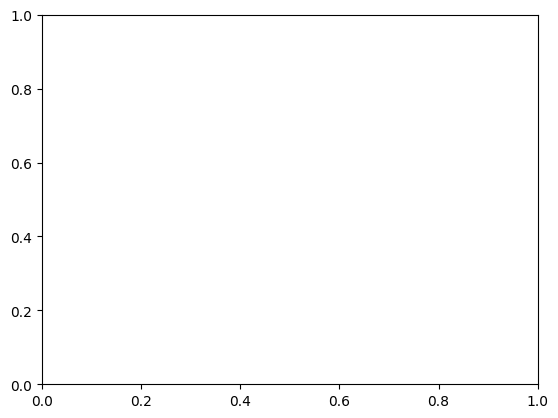

In [78]:
plt.figure()
ax = plt.gca()
loss_tracker["train"]["resnet18_letter_recognition"].plot_acc(
    ax, c="tab:blue"
)
loss_tracker["validation"]["resnet18_letter_recognition"].plot_acc(
    ax, c="tab:orange"
)
plt.title("loss")